In [3]:
#https://blogs.oracle.com/datascience/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend

%run -i start_spark.py --master local[*] --driver-memory 2g
#%run -i start_spark.py --master local[2] spark://192.168.0.100:7077

Creating SparkContext...
SparkContext created.
Master URL: local[*]


**Do not forget to close the session with spark.stop()**

# Fraud detection using machine learning

In the following an unsupervised deep learning (DL) algorithm will be tested to select a model for the fraud detection. The model implements an autoencoder. As the data is higly inbalanced, more algorithms will be used to maximize the performances. Before deep diving in the definition of an DL model, the correlations among variables will be calculated over the whole dataset.


In [5]:
%matplotlib inline

import coursera_common as cc
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import regularizers
from keras.callbacks.tensorboard_v1 import TensorBoard
from keras.callbacks.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import recall_score, classification_report, auc, roc_curve

In [6]:
REBUILD_CACHE = False
SAMPLE = 1

if REBUILD_CACHE \
    or not os.path.exists( cc.AUTOENC_X_TRAIN ) \
    or not os.path.exists( cc.AUTOENC_Y_TRAIN ) \
    or not os.path.exists( cc.AUTOENC_X_TEST ) \
    or not os.path.exists( cc.AUTOENC_Y_TEST ):

    print('Rebuilding cache')
    #Writing payments to parquet
    payments_enc = cc.readParquet(spark, cc.PAYMENTS_ENC_PQT_FILENAME)
    payments_enc.show(5)

    # split train and test df
    print('Split train and test...')

    if SAMPLE < 1:
        train_df, test_df = payments_enc.filter(payments_enc.vDest > int(1E12 * ord('M'))).select(['featuresIndexed', 'isFraud']).sample(fraction=SAMPLE).randomSplit([0.7, 0.3], seed = cc.RANDOM_SEED)
    else:
        train_df, test_df = payments_enc.select(['featuresIndexed', 'isFraud']).randomSplit([0.7, 0.3], seed = cc.RANDOM_SEED)

    print('Training dataset count: {}'.format(train_df.count()))
    print('Test Dataset Count: {}'.format(test_df.count()))

    print('Train # normal: {}'.format(train_df.where(train_df.isFraud==0).count()))
    print('Train # isFraud: {}'.format(train_df.where(train_df.isFraud==1).count()))

    print('Test # normal: {}'.format(test_df.where(test_df.isFraud==0).count()))
    print('Test # isFraud: {}'.format(test_df.where(test_df.isFraud==1).count()))
else:
    print('Load data sets from cache.')

Rebuilding cache
Restoring data/payments_enc.v6.parquet...
Complete!
+----+---------+-------------+--------------+-------+--------------+--------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|step|   amount|oldbalanceOrg|oldbalanceDest|   type|         vOrig|         vDest|isFraud|typeEnc|        corrFeatures|            features|     featuresIndexed|          dlFeatures|   dlFeaturesIndexed|
+----+---------+-------------+--------------+-------+--------------+--------------+-------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 156| 27287.59|   8673566.52|     558897.81|CASH_IN|67001634109320|67001542157370|      0|    2.0|[27287.59,8673566...|[27287.59,8673566...|[27287.59,8673566...|[156.0,27287.59,8...|[156.0,27287.59,8...|
| 156|165163.88|   8700854.11|     272799.53|CASH_IN|67001684617623|67001163394047|      0|    2.0|[165163.88,8

The model is developed using Keras. As the framework works with numpy array, the parquet vector is extracted and cached in numpy binary format for fast reproducibility of the tests.

In [7]:
scaler = StandardScaler()

####### TRAIN
if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_X_TRAIN ):
    print('Loading ' + cc.AUTOENC_X_TRAIN)
    x_train = np.load( cc.AUTOENC_X_TRAIN )
else:
    print('Extracting x_train features as array...')
    x_train = np.array(train_df.select('featuresIndexed').collect())
    x_train = np.apply_along_axis(lambda x : x[0], 1, x_train)
    x_train = scaler.fit_transform(x_train)

    print('Saving ' + cc.AUTOENC_X_TRAIN)
    np.save(cc.AUTOENC_X_TRAIN, x_train)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_Y_TRAIN ):
    print('Loading ' + cc.AUTOENC_Y_TRAIN)
    y_train = np.load( cc.AUTOENC_Y_TRAIN )
else:
    print('Extracting y_train features as array...')
    y_train = np.array(train_df.select('isFraud').collect())
    y_train = np.apply_along_axis(lambda x : x[0], 1, y_train)

    print('Saving ' + cc.AUTOENC_Y_TRAIN)
    np.save(cc.AUTOENC_Y_TRAIN, y_train)
    print('Complete!')

####### TEST
if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_X_TEST ):
    print('Loading ' + cc.AUTOENC_X_TEST)
    x_test = np.load( cc.AUTOENC_X_TEST )
else:
    print('Extracting Test features as array...')
    x_test = np.array(test_df.select('featuresIndexed').collect())
    x_test = np.apply_along_axis(lambda x : x[0], 1, x_test)
    x_test = scaler.fit_transform(x_test)

    print('Saving ' + cc.AUTOENC_X_TEST)
    np.save(cc.AUTOENC_X_TEST, x_test)
    print('Complete!')

if not REBUILD_CACHE and os.path.exists( cc.AUTOENC_Y_TEST ):
    print('Loading ' + cc.AUTOENC_Y_TEST)
    y_test = np.load( cc.AUTOENC_Y_TEST )
else:
    y_test = np.array(test_df.select('isFraud').collect())
    y_test = np.apply_along_axis(lambda x : x[0], 1, y_test)
    print('Complete!')

    print('Saving ' + cc.AUTOENC_Y_TEST)
    np.save(cc.AUTOENC_Y_TEST, y_test)
    print('Complete!')

print('Complete!')

Extracting x_train features as array...
Saving data/autoencoder.x_train.v2.npy
Complete!
Extracting y_train features as array...
Saving data/autoencoder.y_train.v2.npy
Complete!
Extracting Test features as array...
Saving data/autoencoder.x_test.v2.npy
Complete!
Complete!
Saving data/autoencoder.y_test.v2.npy
Complete!
Complete!


A sample of 3000 transactions is selected to plot the data. Dimensions are reduced via PCA.

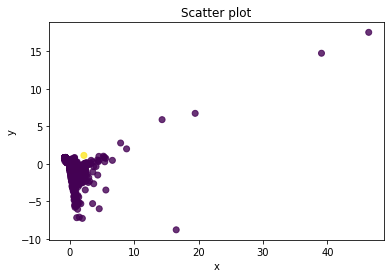

In [8]:
from sklearn.decomposition import PCA

pca_idx = np.random.choice(x_train.shape[0], 3000, replace=False)  

pca = PCA(2)
x_pca = pca.fit_transform(x_train[pca_idx])
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(x_pca['PC1'], x_pca['PC2'], c=y_train[pca_idx], alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:

nb_epoch = 100
batch_size = 256

input_dim = x_train.shape[1]
encoding_dim = 5
hidden_dim = 4  

learning_rate = 0 #1e-5

# Guarantee reproducible results
cc.set_random_seed(cc.RANDOM_SEED)

input_layer = Input(shape=(input_dim, ))

if learning_rate == 0:
    encoder = Dense(encoding_dim, activation="tanh")(input_layer)
else:
    encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)

encoder = Dense(hidden_dim, activation='relu')(encoder)
#encoder = Dense(2, activation='tanh')(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

print(autoencoder.summary())

autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

#cp = ModelCheckpoint(filepath="autoencoder_fraud.h5", save_best_only=True, verbose=5)

#tb = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(x_train, x_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    verbose=1 #,
                    #callbacks=[cp, tb]
                    ).history

#Save model
MODEL_KEY = 'autoenc_v5'

autoencoder.save('models/autoencoder.{}.h5'.format(MODEL_KEY))

#Save configuration
json_config = autoencoder.to_json()
with open('models/autoencoder_config.{}.json'.format(MODEL_KEY), 'w') as json_file:
    json_file.write(json_config)

autoencoder.save_weights('models/autoencoder_weights.{}.json'.format(MODEL_KEY))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 25        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 36        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None
Train on 4454158 samples, validate on 1908462 samples
Epoch 1/100
4454158/4454158 [==============================] - 31s 7

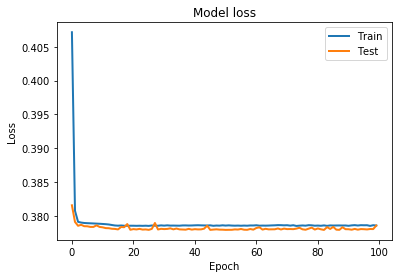

In [10]:
# Model Loss
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [11]:
#Autoencoders are trained to reduce reconstruction error which we show below:
test_x_predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,1.908462e+06,1.908462e+06
mean,3.785902e-01,1.300524e-03
std,9.347246e+00,3.603933e-02
min,2.630259e-04,0.000000e+00
25%,6.764147e-03,0.000000e+00
50%,2.861769e-02,0.000000e+00
75%,6.951410e-02,0.000000e+00
max,3.823367e+03,1.000000e+00


As the data is highly imbalanced the ROC curve does not help to estimate performance of the model. Indeed in this case the precision results nearly 99% as the number of frauds is << 1%. The Precision vs Recall plot can be used to identify a trade off between the two metric.

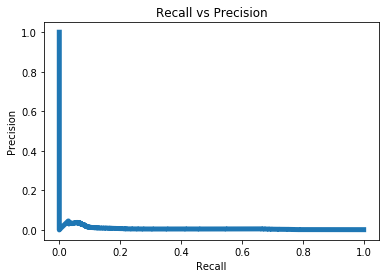

In [12]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

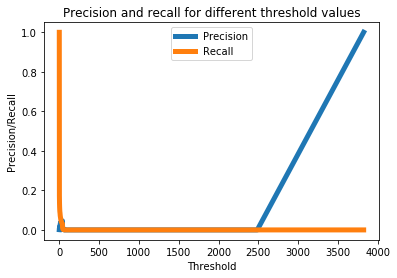

In [13]:
#
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
#plt.xticks(np.arange(min(threshold_rt), max(threshold_rt)+1, 0.002))
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The plot of precision and recall for different thresholds of the reconstruction error helps to identify a balance. As expected the performance of the model are not satisfactory. A threshold of 10 provides the best trade off for the model. 10% of the positives is identified and the odd agains the false negative is approximately 1:38, which is not ideal for a binary classifier. That ratio grows exponentially for decreasing thresholds. For a threshold of 0.1 it becomes 1:207.

Confusion matrix, without normalization
[[1898129    7851]
 [   2280     202]]


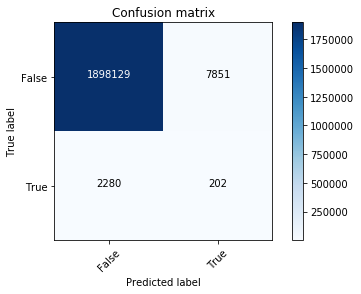

In [20]:
#Check prediction
threshold_fixed = 10 # 10 per v4 e modello salvato

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

cc.plot_confusion_matrix(conf_matrix, classes=['False','True'], normalize=False)